In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchsummary import summary
import torch.nn.functional as F
from GaussianNoise import decay_gauss_std,set_gauss_std


# library to get dataloader
from dataloaders import get_pkmn_dataloader

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func,gradient_penalty,get_gradient

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout
from DiscriminatorPatchGAN import DiscriminatorPatchGAN,DiscriminatorPatchGANConditional
from DCGeneratorConditionalLarge import DCGeneratorConditionalLarge

from DCGeneratorConditional import DCGeneratorConditional
from DCGeneratorConditionalLarge import DCGeneratorConditionalLarge
from DCDiscriminatorConditional import DCDiscriminatorConditional
from DCDiscriminatorConditionalLarge import DCDiscriminatorConditionalLarge
from UNetArchitecture import UNet,UNetConditional,UNetConditionalImage

# util methods
from utils import get_noise,get_image_noise,get_incorrect_labels_for_real

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES,REDUCED_PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE_REDUCED

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))


torch.cuda.empty_cache()

Using device: cpu


In [2]:
print(torch.__version__)

# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None, use_uniform_transform = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    # We don't specifically need this since we are doing the denormalization ourself
    
    if denorm_transform is not None:
      assert use_uniform_transform == False
      image_tensor = denorm_transform(image_tensor)
    if use_uniform_transform:
      # cannot use both uniform and denorm transform together
      assert denorm_transform == None
      image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def save_model(model, output_filename):
  torch.save(model.state_dict(), output_filename)

1.10.2


In [3]:
# Test out the conditional Unet with image input (to get # of parameters)
test_unet =UNetConditionalImage(input_channels = 2, output_channels = 3, 
                            hidden_channels = 12, input_dim=64, 
                            use_class_embed=False, 
                            class_embed_size=16, use_conditional_layer_arch=False, vocab_size=16,
                            inject_noise = True, use_class_adapt_layer = True)

out = test_unet(torch.ones(7, 1, 64, 64), torch.ones(7, 1))

print("Output shape of unet is: {}".format(out.shape))

summary(test_unet, [(1, 64, 64), (1, 1)], device = 'cpu')


Using class adapative layer!!!
Output shape of unet is: torch.Size([7, 3, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 64, 64]              36
   FeatureMapBlock-2           [-1, 12, 64, 64]               0
            Conv2d-3           [-1, 24, 64, 64]           2,616
       BatchNorm2d-4           [-1, 24, 64, 64]              48
           Dropout-5           [-1, 24, 64, 64]               0
         LeakyReLU-6           [-1, 24, 64, 64]               0
            Conv2d-7           [-1, 24, 64, 64]           5,208
       BatchNorm2d-8           [-1, 24, 64, 64]              48
           Dropout-9           [-1, 24, 64, 64]               0
        LeakyReLU-10           [-1, 24, 64, 64]               0
        MaxPool2d-11           [-1, 24, 32, 32]               0
 ContractingBlock-12           [-1, 24, 32, 32]               0
        Embedding-13

/Users/moose_abdool/miniconda3/envs/cs236g_py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


TypeError: can't multiply sequence by non-int of type 'tuple'

In [4]:
# Test out the conditional Unet with vector + tiling input(to get # of parameters)
test_unet = UNetConditional(input_channels = 1, output_channels = 3, 
                            hidden_channels = 8, input_dim=64, 
                            use_class_embed=True, z_dim = 16,
                            class_embed_size=16, use_conditional_layer_arch=False, vocab_size=16,
                            use_mapping_network = True, map_network_hidden_size = 1024
                            )

out = test_unet(torch.ones(7, 16), torch.ones(7, 1))

print("Output shape of unet is: {}".format(out.shape))

summary(test_unet, [(1, 16), (1, 1)], device = 'cpu')


Output shape of unet is: torch.Size([7, 3, 64, 64])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 1, 1, 16]             256
            Linear-2                 [-1, 1024]          33,792
              ReLU-3                 [-1, 1024]               0
            Linear-4                 [-1, 1024]       1,049,600
              ReLU-5                 [-1, 1024]               0
            Linear-6                   [-1, 32]          32,800
    MappingNetwork-7                   [-1, 32]               0
            Conv2d-8            [-1, 8, 64, 64]              16
   FeatureMapBlock-9            [-1, 8, 64, 64]               0
           Conv2d-10           [-1, 16, 64, 64]           1,168
      BatchNorm2d-11           [-1, 16, 64, 64]              32
          Dropout-12           [-1, 16, 64, 64]               0
        LeakyReLU-13           [-1, 16, 64, 64]    

In [5]:
# What are the differences here?
# PatchGan input is (3x96x96)
# output is 6x6 patches if input dim is 96
# output is 8x8 patches if input dim is 128
# Basically, it's easy to change the shape of the input dimension image, we just create more patches

test_patchgan = DiscriminatorPatchGANConditional(input_channels = 3, hidden_channels = 2, input_image_dim=64,
                                                use_class_proj = True)

patchgan_out = test_patchgan(torch.ones(7, 3, 64, 64), torch.ones(7, 1))

print("Shape of patchgan output is: {}".format(patchgan_out.shape))

summary(test_patchgan, [(3, 64, 64), (1,1)], device = 'cpu')

Shape of patchgan output is: torch.Size([7, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                   [-1, 16]             288
            Conv2d-2            [-1, 2, 64, 64]              10
   FeatureMapBlock-3            [-1, 2, 64, 64]               0
            Conv2d-4            [-1, 4, 64, 64]              76
         LeakyReLU-5            [-1, 4, 64, 64]               0
            Conv2d-6            [-1, 4, 64, 64]             148
         LeakyReLU-7            [-1, 4, 64, 64]               0
         MaxPool2d-8            [-1, 4, 32, 32]               0
  ContractingBlock-9            [-1, 4, 32, 32]               0
           Conv2d-10            [-1, 8, 32, 32]             296
      BatchNorm2d-11            [-1, 8, 32, 32]              16
        LeakyReLU-12            [-1, 8, 32, 32]               0
           Conv2d-13            [-1, 8, 32, 32]        

TypeError: can't multiply sequence by non-int of type 'tuple'

In [6]:
# ======= Define the basic hyper-parameters =====


# training epochs
n_epochs = 1

# Generator parameters
use_unet_image = False
use_unet_conditional = True

assert use_unet_image != use_unet_conditional


hidden_dim_gen = 4
z_dim = 20 # dimension of noise vector (if using UNetConditional)
gen_input_image_size = 64 # dimension of input image size (if using UNetConditionalImage)
use_noise_upsampling = False
original_noise_dim = 32
use_gen_class_embed = True
gen_class_embed_size = 12
use_mapping_network = False
map_network_hidden_size = 1024 # only used in UnetConditional
use_conditional_layer_arch = True
use_gen_dropout = False
dropout_gen_prob = 0.1
vocab_size = 13

# noise and adapative class layer
use_gen_noise = False # whether or not to inject noise to gen layers using the class
use_class_ada_layer = True
class_adapt_layer_embed_size = 32
use_middle_noise = True
middle_noise_std = 0.02


# Discriminator Parameters
use_patchgan_disc=False
use_dropout_disc = True
patchgan_dropout = 0.1
hidden_dim_disc = 8 # was 64
disc_class_embed_size = 4
use_class_embed_disc = True
early_dropout = 0.4
mid_dropout = 0.2
late_dropout = 0.1
use_gaussian_noise = True
gaussian_noise_std = 0.1
use_class_proj = False


# General Parameters - batch size and dataset
batch_size = 64 # 64 works
# Whether to train the discriminator using real images but the wrong class (to help it learn class information)
neg_sample_bs = 16
use_neg_samples = True

assert neg_sample_bs < batch_size
dataloader_name = "conditional_64_no_shiny_mainclass_flip_rotate_standard_norm"
#"conditional_64_dim_no_shiny_with_flip_and_rotate_and_standard_norm"
#"conditional_64_dim_mainclass_with_shiny_flip_rotate_custom_norm"

# how often to display images and debug info. Basically, the numerator is how many images you want to
# process before showing some debug info
display_step = int((4000 / batch_size))
periodic_saving = True
# after how many epochs do you save the model?
epoch_save_step = 20
save_prefix = "experiment_16/test_unet_and_dcdiscriminator_class_proj_conditional_layer"
imgs_to_display = 10

print("Planning to display images every {} steps".format(display_step))

# other sources say 0.00275 works better...but the DCGAn paper used 0.0002 (ie. about 10-4 instead of 10-3)
gen_lr = 0.0002 # 0.0002 works for both, but takes at least 10-15 epochs before anything interesting happens?
disc_lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
disc_repeats = 1
gen_repeats = 1

use_acgan = True
ac_gan_lambda = 0.1

# loss functions used
if use_patchgan_disc:
  gen_loss_func = get_generator_loss_func("basic_gen_loss_with_logits") # basic_gen_loss_with_logits
  disc_loss_func = get_disc_loss_func("noisy_patchgan_disc_loss") # noisy_patchgan_disc_loss
elif use_acgan:
  gen_loss_func = get_generator_loss_func("gen_loss_ACGAN") # basic_gen_loss_with_logits
  disc_loss_func = get_disc_loss_func("disc_loss_ACGAN") # noisy_patchgan_disc_loss  
else:
  gen_loss_func = get_generator_loss_func("basic_gen_loss")
  disc_loss_func = get_disc_loss_func("noisy_disc_loss")    

assert imgs_to_display <= batch_size

Planning to display images every 62 steps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of dataset (number of steps) is: 116, total size is: 7424


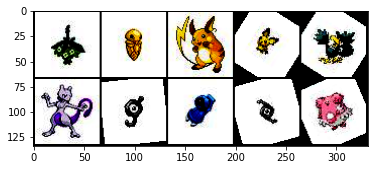

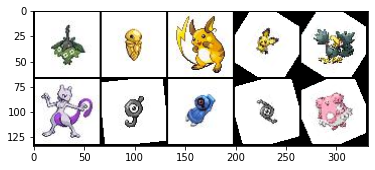

In [7]:
# Create the dataloader, based on the appropriate batch size. 

use_reduced_types = True
show_preview = True

pkmn_dataloader, denorm_transform = get_pkmn_dataloader(dataloader_name, batch_size,num_workers=0)
test_size = 10

# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("length of dataset (number of steps) is: {}, total size is: {}".format(len(pkmn_dataloader), len(pkmn_dataloader)*batch_size))

if show_preview:
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = None)
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = denorm_transform)

if use_reduced_types:
  valid_types = REDUCED_PKMN_TYPES
  class_idx_to_type = CLASS_IDX_2_PKMN_TYPE_REDUCED
else:
  valid_types = PKMN_TYPES
  class_idx_to_type = CLASS_IDX_2_PKMN_TYPE
  
num_pkmn_types = len(valid_types)

In [8]:
# Create the generator/discriminator and use them
# layer initialization for Generator and Discriminator (for Conv2d and ConvTranpose2d)
#gen = DCGeneratorConditionalLarge(z_dim = z_dim, hidden_dim = hidden_dim_gen, output_dim = 96, use_class_embed = False, class_embed_size = 16).to(device)


if use_unet_image:
  print("Using image unet")
  gen = UNetConditionalImage(input_channels = 2, output_channels = 3, 
                             hidden_channels = hidden_dim_gen, input_dim=gen_input_image_size, 
                             use_class_embed=use_gen_class_embed, class_embed_size=gen_class_embed_size,
                             vocab_size=num_pkmn_types,
                             use_conditional_layer_arch=use_conditional_layer_arch,# not sure if this makes sense here ?
                             use_mapping_network = use_mapping_network, map_network_hidden_size = map_network_hidden_size,
                             inject_noise = use_gen_noise, use_class_adapt_layer = use_class_ada_layer,
                             use_middle_noise = use_middle_noise, middle_noise_std = middle_noise_std).to(device)

else:
  print("Using basic conditional Unet!")
  gen = UNetConditional(z_dim = z_dim, 
                        hidden_channels= hidden_dim_gen,
                        input_dim = 64, 
                        use_dropout = use_gen_dropout, dropout_prob = dropout_gen_prob,
                        vocab_size = num_pkmn_types,
                        use_class_embed=use_gen_class_embed, class_embed_size=gen_class_embed_size,
                        use_mapping_network = use_mapping_network, map_network_hidden_size = map_network_hidden_size,
                        inject_noise = use_gen_noise, use_class_adapt_layer = use_class_ada_layer,
                        class_adapt_layer_embed_size = class_adapt_layer_embed_size
                        ).to(device)




if use_patchgan_disc:
    print("Using patchgan discriminator!")
    disc = DiscriminatorPatchGANConditional(hidden_channels = hidden_dim_disc,              
                                            use_dropout = use_dropout_disc, 
                                            input_image_dim = 64,
                                            dropout_prob = patchgan_dropout,
                                            class_embed_size = disc_class_embed_size,
                                            use_gaussian_noise = use_gaussian_noise,
                                            gaussian_noise_std = gaussian_noise_std,
                                            use_class_proj = use_class_proj,
                                            use_multi_loss = use_acgan, 
                                            num_pkmn_types = num_pkmn_types).to(device)

else:
    print("Using dc discriminator!")
    disc = DCDiscriminatorConditional(hidden_dim = hidden_dim_disc, class_embed_size=disc_class_embed_size,
                                      use_dropout = use_dropout_disc, early_dropout=early_dropout, 
                                      mid_dropout = mid_dropout,
                                      late_dropout = late_dropout, use_gaussian_noise = use_gaussian_noise,
                                      gaussian_noise_std = gaussian_noise_std,
                                      use_class_proj = use_class_proj,
                                      use_multi_loss = use_acgan,
                                      num_pkmn_types = num_pkmn_types).to(device)  
  
gen_opt = torch.optim.Adam(gen.parameters(), lr=gen_lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=disc_lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


#summary(disc, [(3, 64, 64), (1,1)], device = 'cpu')

Using basic conditional Unet!
Using class adapative layer!!!
Using dc discriminator!
==== Using dropout in discriminator!!
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1


In [ ]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

cur_step = 0
generator_losses = []
discriminator_losses = []
discriminator_fake_preds = [] # median value of P(real) the discriminator predicts on the fake images (per batch)
discriminator_real_preds = [] # median value of P(real) the discriminator predicts on the real images (per batch)
if use_patchgan_disc:
    agg_func = nn.Sigmoid() # use this if you have logit outputs
else:
    agg_func = nn.Identity()

for epoch in range(n_epochs):
    # Dataloader returns the (real_images, labels)
    for real, true_labels in tqdm(pkmn_dataloader):
      
        # shape: (neg_sample_bs, 1)
        neg_sample_labels = get_incorrect_labels_for_real(true_labels, neg_sample_bs, num_pkmn_types, device = device).view(neg_sample_bs, 1)
        neg_sample_real_images = real[0:neg_sample_bs, :, :, :]

        cur_batch_size = len(real)
        real = real.to(device)
        true_labels = true_labels.to(device)
        
        mean_iteration_discriminator_loss = 0
        for _ in range(disc_repeats):
            ### Update discriminator ###
            disc_opt.zero_grad()
            if use_unet_image:
              fake_noise = get_image_noise(cur_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
            else:
              fake_noise = get_noise(cur_batch_size, z_dim, device=device)

            fake = gen(fake_noise, true_labels)
            
            disc_fake_pred = disc(fake.detach(), true_labels)
            disc_real_pred = disc(real, true_labels)
            
            if use_neg_samples:
              disc_pred_fake_labels_but_real = disc(neg_sample_real_images, neg_sample_labels)
              disc_fake_pred = torch.cat((disc_fake_pred, disc_pred_fake_labels_but_real), axis=0)
              
            print("Shape of fake pred: {}, real pred: {}".format(disc_fake_pred.shape, disc_real_pred.shape))  
              
            # compute discriminator loss normally
            if use_acgan:
              disc_loss = disc_loss_func(disc_fake_pred, disc_real_pred, true_labels, num_pkmn_types, ac_gan_lambda, device, debug = True)
            else:
              disc_loss = disc_loss_func(disc_fake_pred, disc_real_pred, device)

            # Keep track of the average discriminator loss in this batch
            mean_iteration_discriminator_loss += disc_loss.item() / disc_repeats
            
            # Update gradients
            # when using WGAN, we need to have retain_graph = True, but it probably takes longer
            disc_loss.backward(retain_graph=False)
            
            # Update optimizer
            disc_opt.step()
                        
        discriminator_losses += [mean_iteration_discriminator_loss]
        # notice this only takes the last one from the iteration (if you run the discriminator multiple times)
        # use a Sigmoid here to go from logits back into the P(real) space
        discriminator_fake_preds += [agg_func(torch.mean(disc_fake_pred).detach())]
        discriminator_real_preds += [agg_func(torch.mean(disc_real_pred).detach())]

        ### Update generator ###
        mean_iteration_gen_loss = 0
        for _ in range(gen_repeats):
          gen_opt.zero_grad()
          if use_unet_image:
            fake_noise_2 = get_image_noise(cur_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
          else:
            fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)          
          fake_2 = gen(fake_noise_2, true_labels)
          disc_fake_pred = disc(fake_2, true_labels)

          # compute gen loss
          if use_acgan:
            gen_loss = gen_loss_func(disc_fake_pred, true_labels, num_pkmn_types, ac_gan_lambda, device, debug = True)
          else:
            gen_loss = gen_loss_func(disc_fake_pred, device)
          
          mean_iteration_gen_loss += gen_loss.item() / gen_repeats
          
          gen_loss.backward()

          # Update the weights
          gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [mean_iteration_gen_loss]
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            # maybe print out the last values here ? To see how stable it is overtime ? These all seem to be very close to 0.5 / 1
            disc_prediction_real = sum(discriminator_real_preds[-display_step:]) / display_step
            disc_prediction_fake = sum(discriminator_fake_preds[-display_step:]) / display_step
            print(f"Step {cur_step}: Epoch: {epoch}: Generator loss: {gen_mean}, discriminator loss: {disc_mean} mean disc pred on real images: {disc_prediction_real}, fake images: {disc_prediction_fake}")
            show_tensor_images(fake[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            show_tensor_images(real[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            
            ground_truth_types = [class_idx_to_type[class_idx] for class_idx in true_labels[0:imgs_to_display].cpu().numpy()]
            print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(ground_truth_types[0:5], ground_truth_types[5:]))
            
            step_bins = 20
            
            # todo: add proper labels to this plot
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="discriminator Loss"
            )
            plt.legend()
            plt.show()
        
        # increase the current step (ie. one batch)
        cur_step += 1
        
    if periodic_saving and epoch % epoch_save_step == 0 and epoch > 0:
      outfile_name = "{}_{}.pt".format(save_prefix, cur_step)
      print("===== Saving intermediate model with name {} ! ====".format(outfile_name))
      save_model(gen, outfile_name)

  0%|          | 0/116 [00:00<?, ?it/s]

Shape of fake pred: torch.Size([80, 15]), real pred: torch.Size([64, 15])
disc source losses ==> real images: 0.5578886866569519, fakes images: 0.8521467447280884
disc class distribution losses ==> real images: 2.5937654972076416, fakes images: 2.831840991973877
gen source losses ==>  fake images: 0.8607693910598755
gen class distribution losses ==> fakes images: 2.596945285797119
Shape of fake pred: torch.Size([80, 15]), real pred: torch.Size([64, 15])
disc source losses ==> real images: 0.5593000650405884, fakes images: 0.850960910320282
disc class distribution losses ==> real images: 2.6180903911590576, fakes images: 2.824871063232422
gen source losses ==>  fake images: 0.8618590831756592
gen class distribution losses ==> fakes images: 2.607966661453247
Shape of fake pred: torch.Size([80, 15]), real pred: torch.Size([64, 15])
disc source losses ==> real images: 0.5597981810569763, fakes images: 0.8558277487754822
disc class distribution losses ==> real images: 2.597670078277588, fak

In [ ]:
# Save the final model

out_file = "experiment_11/unet_and_dcgan_exp_11_fulltrain.pt"
  
save_model(gen, out_file)

In [ ]:
# Load model for inference and to generate samples (note: GANs use train mode still)

gen.load_state_dict(torch.load("{}".format(out_file)))
gen.train() # Basically, we don't want to use eval mode for GANs, due to the batchnorm layers

In [ ]:
### Perform inference for a random batch of Pokemon types


test_batch_size = 96 # this should be larger in order to have accurate batchnorm layers
samples_to_show = 10

if use_unet_image:
    sample_vector = get_image_noise(test_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
else:
    sample_vector = get_noise(test_batch_size, z_dim, device=device)    

random_classes = torch.randint(low = 0, high = num_pkmn_types, size = (test_batch_size,)).to(device)
fake_images = gen(sample_vector, random_classes)


show_tensor_images(fake_images, num_images=samples_to_show,      
                   size=(1,256, 256), 
                   use_uniform_transform = False, 
                   denorm_transform = denorm_transform)


pkmn_classes = [class_idx_to_type[class_idx] for class_idx in random_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:10]))


In [ ]:
### Perform inference for a specific Pokemon type

test_batch_size = 96 # this should be larger in order to have accurate batchnorm layers
samples_to_show = 10

target_type = 'Dragon'
target_class_idx = valid_types.index(target_type)

if use_unet_image:
    sample_vector = get_image_noise(test_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
else:
    sample_vector = get_noise(test_batch_size, z_dim, device=device)    

random_classes = torch.randint(low = 0, high = num_pkmn_types, size = (test_batch_size,)).to(device)
fake_images = gen(sample_vector, random_classes)

type_class_mask = random_classes == target_class_idx

fake_images_of_target_type = fake_images[type_class_mask]
target_classes = random_classes[type_class_mask]


show_tensor_images(fake_images_of_target_type, num_images=samples_to_show,      
                   size=(1,256, 256), 
                   use_uniform_transform = False, 
                   denorm_transform = denorm_transform)


pkmn_classes = [class_idx_to_type[class_idx] for class_idx in target_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:10]))


In [ ]:
# Sample images and save to a file (for FID score comparison)
from PIL import Image

num_images = 128

test_batch_size = 1000 # this should be larger in order to have accurate batchnorm layers
num_batches = int(num_images/test_batch_size)

outpath = "./pkmn_samples"

for b in range(num_batches):
    if use_unet_image:
        sample_vector = get_image_noise(test_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
    else:
        sample_vector = get_noise(test_batch_size, z_dim, device=device)    

    random_classes = torch.randint(low = 0, high = num_pkmn_types, size = (test_batch_size,)).to(device)
    fake_images = gen(sample_vector, random_classes).detach().cpu()
    
    
    for i in range(len(fake_images)):
        im_denormed = np.transpose(denorm_transform(fake_images[i,:,:,:]).view(3,64,64).numpy(), (1,2,0))
        pil_im = Image.fromarray((im_denormed * 255).astype(np.uint8))
        pil_im.save("{}/pkmn_image_{}_{}.png".format(outpath, b, i))
        break
        
    break

In [ ]:
# using true labels 